In [1]:
import pathlib
import json

In [2]:
import influxdb
import pandas as pd

In [3]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

## Parameters

In [4]:
t0 = pd.Timestamp('2020-06-22 13:00:00', tz='CET').tz_convert('UTC')
#t0 = pd.Timestamp('2020-06-20 13:00:00', tz='CET').tz_convert('UTC')
t0

Timestamp('2020-06-22 11:00:00+0000', tz='UTC')

In [5]:
t1 = pd.Timestamp.utcnow()
t1

Timestamp('2020-06-22 15:01:07.460694+0000', tz='UTC')

## Irceline Reference

In [6]:
cref = Irceline()

In [7]:
sel = cref.select(sitekey='41', measurekey='PM')

In [8]:
sel.shape

(11, 25)

In [9]:
recs = cref.get_records(sel, start=t0, stop=t1)

In [10]:
keys = ['measurekey', 'sitekey', 'serieid']

In [11]:
dref = recs.merge(sel[keys]).pivot_table(index='start', columns=keys, values='value')

In [12]:
dref.tail()

measurekey                PM-10.0                                    PM-2.5  \
sitekey                    41B011 41MEU1 41N043 41R001 41R012 41WOL1 41B011   
serieid                      6531   6552   6563   6578   6626   6643   6532   
start                                                                         
2020-06-22 11:00:00+00:00     NaN   20.0   25.0   18.5   19.0   14.0    NaN   
2020-06-22 12:00:00+00:00    13.0   15.5   24.0   19.0   21.5   53.5    5.4   
2020-06-22 13:00:00+00:00     NaN   13.5   24.0   17.5   21.5   15.5    NaN   

measurekey                                             
sitekey                   41MEU1 41N043 41R001 41R012  
serieid                     6553   6564   6579   6627  
start                                                  
2020-06-22 11:00:00+00:00  15.90  10.95   7.25    9.7  
2020-06-22 12:00:00+00:00  12.00   7.95   9.90   10.4  
2020-06-22 13:00:00+00:00   7.75   7.80   5.90   10.9

## SDS Benchmark

In [13]:
with pathlib.Path('C:/Users/admin/udlog/influx.json').open() as fh:
    client = influxdb.InfluxDBClient(**json.load(fh))

In [14]:
client.ping()

'1.8.0'

In [15]:
query = """
SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '{start:}' AND time < '{stop:}'
GROUP BY time(1h)
""".format(start=t0.isoformat(), stop=t1.isoformat())
print(query)


SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '2020-06-22T11:00:00+00:00' AND time < '2020-06-22T15:01:07.460694+00:00'
GROUP BY time(1h)



In [16]:
r = client.query(query).raw['series'][0]

In [17]:
dsds = pd.DataFrame(r['values'], columns=r['columns'])
dsds['time'] = pd.to_datetime(dsds['time'])
dsds = dsds.set_index('time')
dsds.columns = pd.MultiIndex.from_tuples([('PM-2.5', 'Home', '1'), ('PM-10.0', 'Home', '2')])
dsds.tail()

,PM-2.5,PM-10.0
,Home,Home
,1,2
time,,
2020-06-22 11:00:00+00:00,6.081676,17.273886
2020-06-22 12:00:00+00:00,5.362688,18.474122
2020-06-22 13:00:00+00:00,5.937312,19.906051
2020-06-22 14:00:00+00:00,6.329060,19.183058
2020-06-22 15:00:00+00:00,6.355224,18.502985


## Data Merge

In [18]:
df = pd.concat([dref, dsds], axis=1)
df.tail()

measurekey                PM-10.0                                    PM-2.5  \
sitekey                    41B011 41MEU1 41N043 41R001 41R012 41WOL1 41B011   
serieid                      6531   6552   6563   6578   6626   6643   6532   
2020-06-22 11:00:00+00:00     NaN   20.0   25.0   18.5   19.0   14.0    NaN   
2020-06-22 12:00:00+00:00    13.0   15.5   24.0   19.0   21.5   53.5    5.4   
2020-06-22 13:00:00+00:00     NaN   13.5   24.0   17.5   21.5   15.5    NaN   
2020-06-22 14:00:00+00:00     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2020-06-22 15:00:00+00:00     NaN    NaN    NaN    NaN    NaN    NaN    NaN   

measurekey                                                         PM-10.0  
sitekey                   41MEU1 41N043 41R001 41R012      Home       Home  
serieid                     6553   6564   6579   6627         1          2  
2020-06-22 11:00:00+00:00  15.90  10.95   7.25    9.7  6.081676  17.273886  
2020-06-22 12:00:00+00:00  12.00   7.95   9.90   10.4  5.362688  18.474122  
2020-06-22 13:00:00+00:00   7.75   7.80   5.90   10.9  5.937312  19.906051  
2020-06-22 14:00:00+00:00    NaN    NaN    NaN    NaN  6.329060  19.183058  
2020-06-22 15:00:00+00:00    NaN    NaN    NaN    NaN  6.355224  18.502985

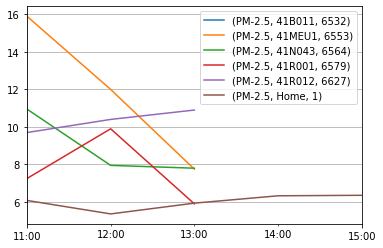

In [19]:
axe = df.filter(regex='2.5').plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

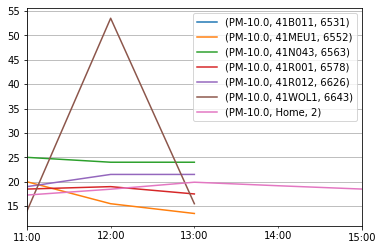

In [20]:
axe = df.filter(regex='10.0').plot()
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

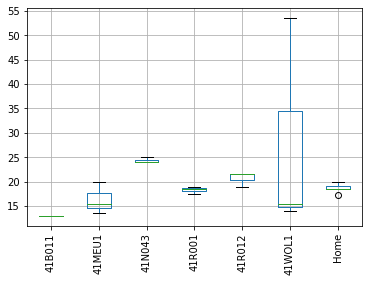

In [21]:
axe = df.filter(regex='10.0').droplevel([0,-1], axis=1).boxplot(rot=90)

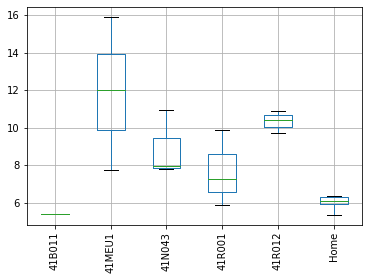

In [22]:
axe = df.filter(regex='2.5').droplevel([0,-1], axis=1).boxplot(rot=90)